## BSL

This notebook demonstrates how to use the BSL methods version available [here](https://github.com/uremes/elfi/tree/update_bsl). Based on the notebook available [here](https://github.com/RyanJafefKelly/notebooks/blob/bsl_notebooks/bsl.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import elfi

seed = 1
np.random.seed(seed)

In [2]:
from elfi.methods.bsl import pdf_methods, pre_sample_methods

We use the MA(2) model introduced in [ELFI tutorial](https://elfi.readthedocs.io/en/latest/usage/tutorial.html).

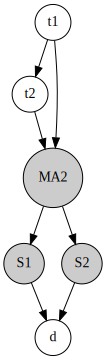

In [3]:
from elfi.examples import ma2
m = ma2.get_model(n_obs=50, seed_obs=seed)
elfi.draw(m)

The BSL version demonstrated in this notebook does not use a synthetic likelihood node, but the two tasks discussed in the previous notebook remain the same: 1. define how the likelihood scores are calculated: likelihood function, feature representation, simulation count 2. sample the approximate posterior calculated based on the likelihood scores. 

- likelihood

The likelihood function is expected to use observed and simulated features to calculate an estimate for the log-likelihood that the same parameter values produced the observed and simulated features. 

Here we choose the standard synthetic likelihood estimation method. This method approximates the simulated feature distribution with a multivariate normal distribution.

In [4]:
likelihood = pdf_methods.bsl_likelihood()

- features

Features used in likelihood calculation must be included as observable nodes in the ELFI model. Observable nodes in the preset MA(2) model include the simulator node `MA2` and the summaries `S1` and `S2`. To match examples used in the BSL literature, we do not summarise the observed or simulated data but estimate the synthetic likelihood based on observed and simulated data. 

In [5]:
feature_names = 'MA2'

Note: the functions that let us examine the selected features and assess relevant feature properties are now collected in their own module and separate from the sampler. This means that we do not need to decide on a likelihood function or create a sampler to use `plot_covariance_matrix` or `plot_features`.

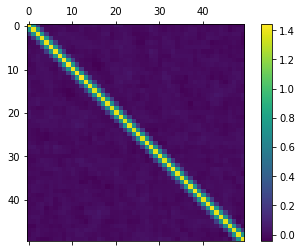

In [6]:
params = {'t1': 0.6, 't2': 0.2}
nsim = 10000
pre_sample_methods.plot_covariance_matrix(m, params, nsim, feature_names)

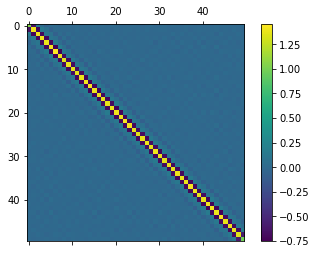

In [7]:
pre_sample_methods.plot_covariance_matrix(m, params, nsim, feature_names, precision=True)

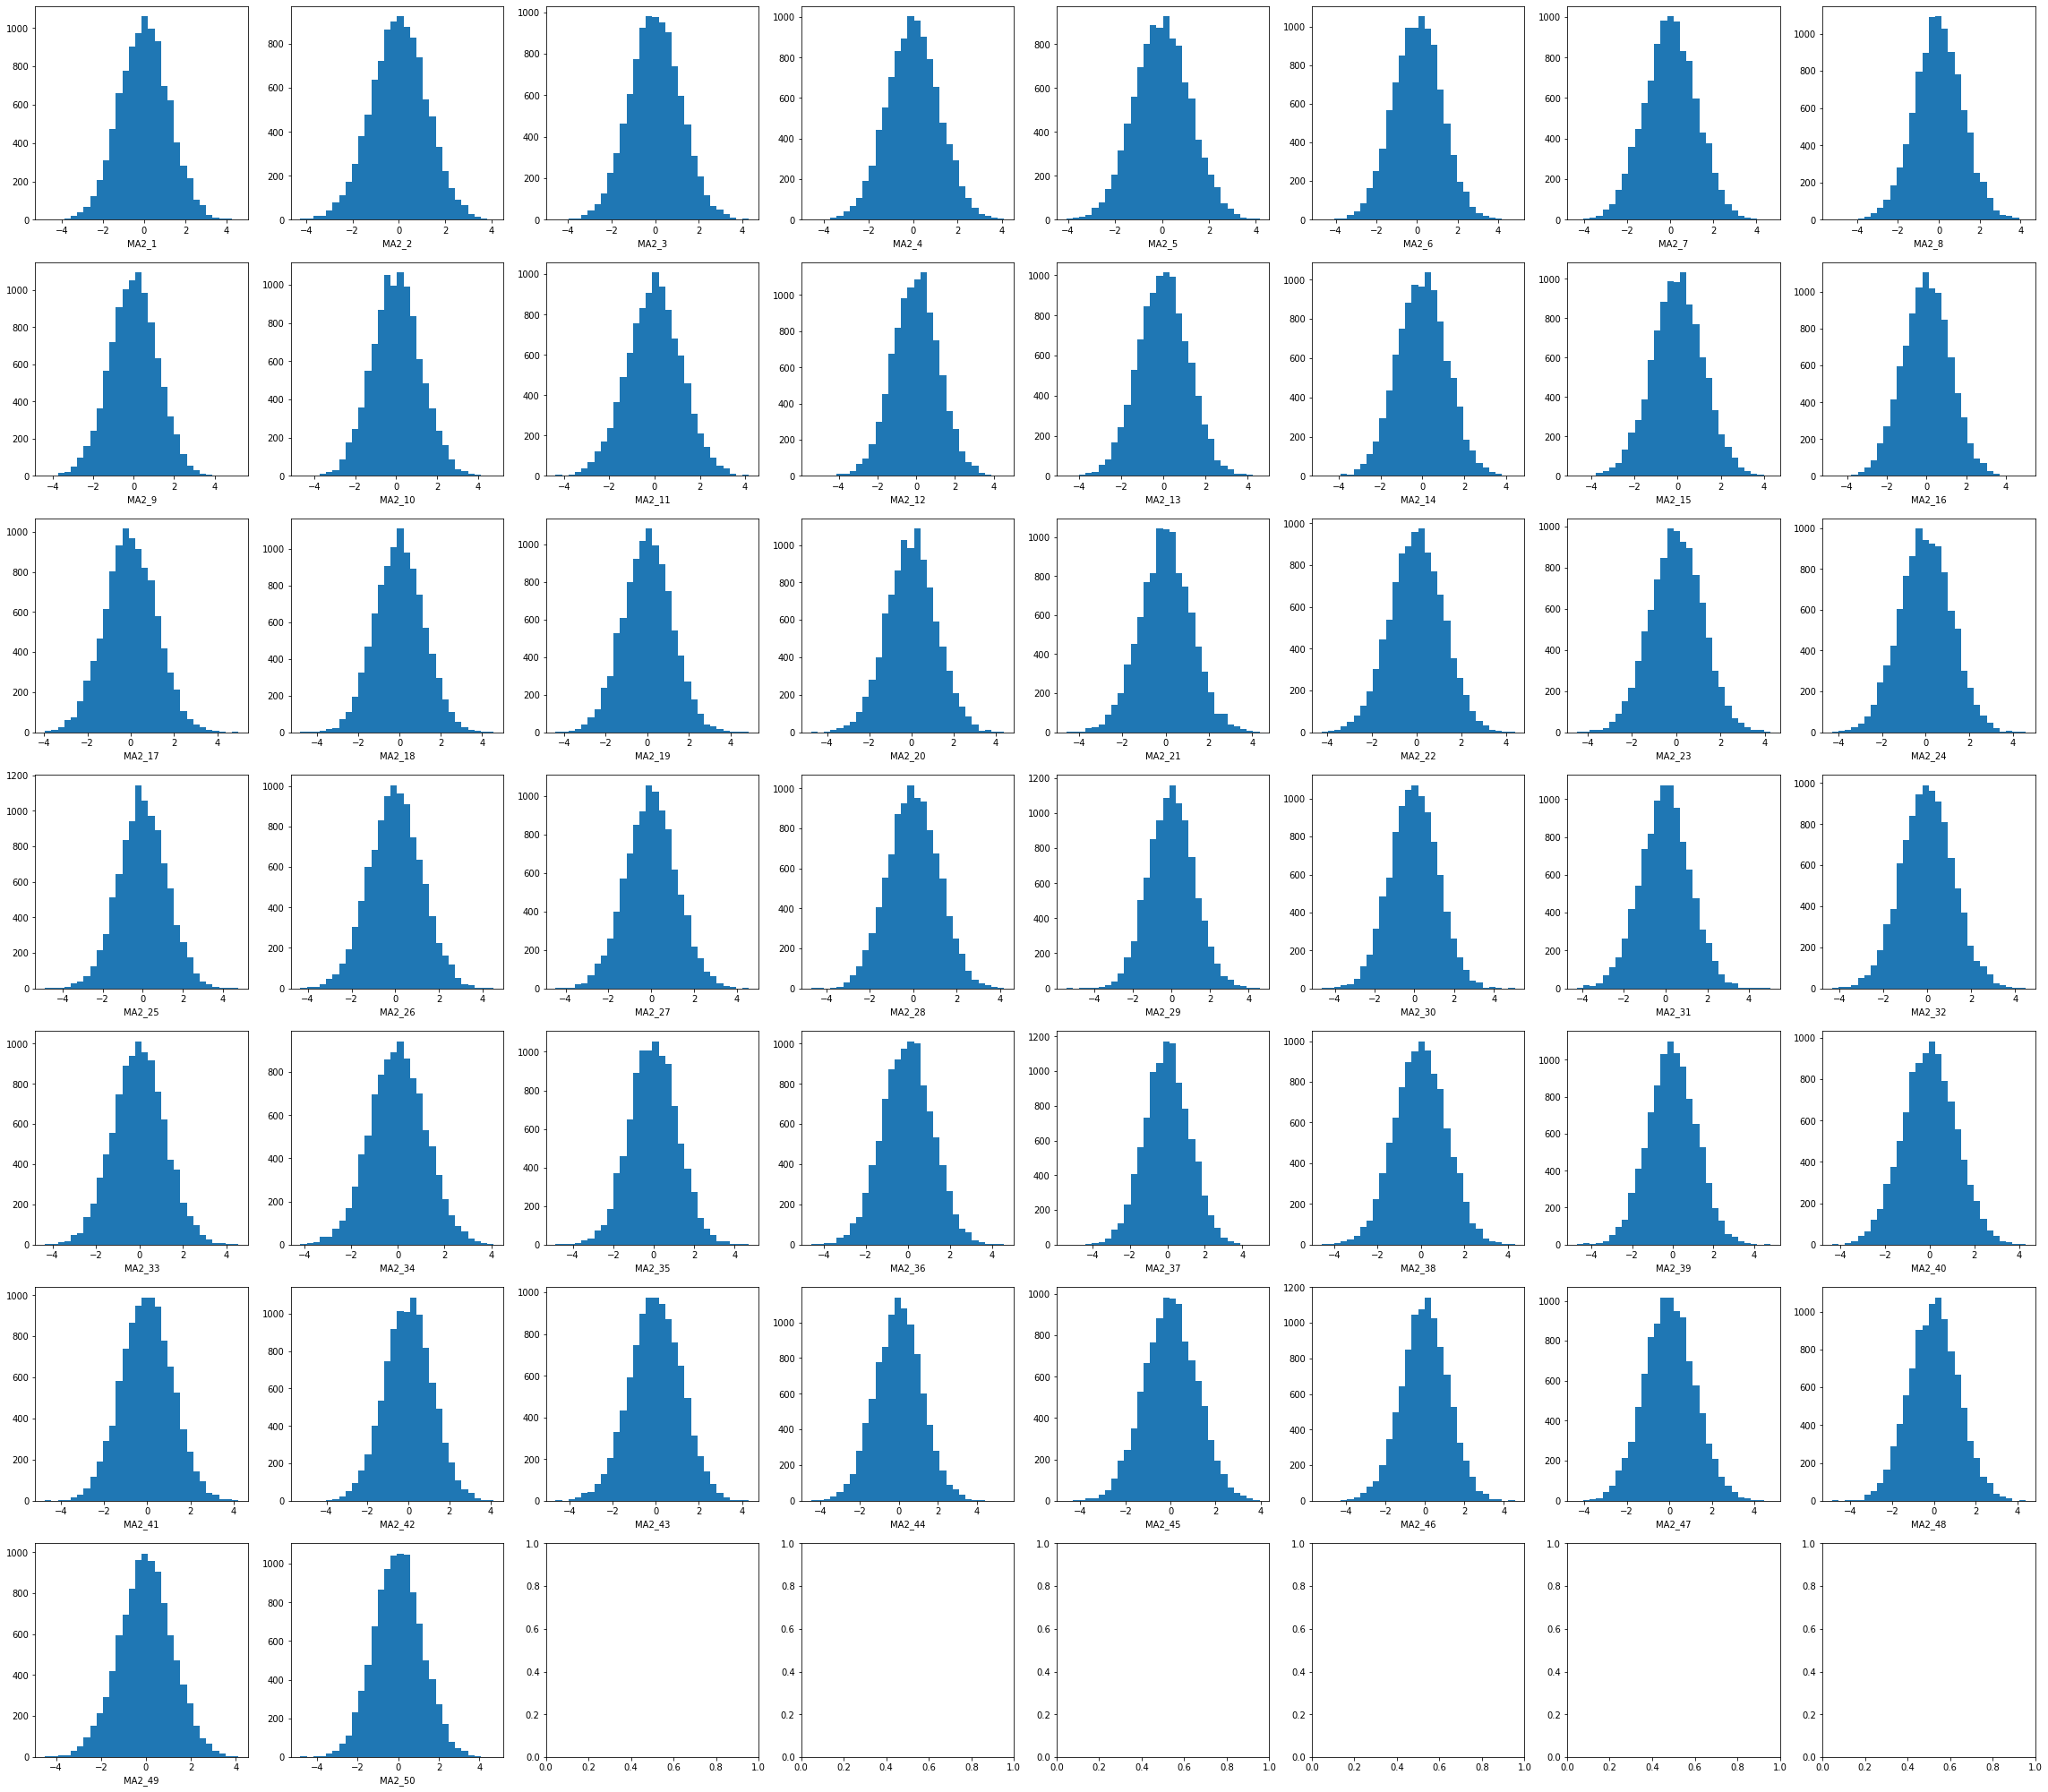

In [8]:
pre_sample_methods.plot_features(m, params, nsim, feature_names)

- simulation count

The synthetic likelihood scores are calculated based on the observed features and a parametric distribution model estimated based on `nsim_round` simulated features. `nsim_round` should be selected so that the standard deviation between log-likelihood scores is between 1 and 2.

In [9]:
nsim_round = 500
std_value = pre_sample_methods.log_SL_stdev(m, params, nsim_round, feature_names, likelihood=likelihood, M=100)
std_value

1.7301899697792167

Now we can create the sampler instance:

In [10]:
standard_bsl = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

We see here that `feature_names` and `likelihood` are optional parameters. `feature_names` defaults to all summary nodes in model `m` and `likelihood` defaults to the standard synthetic likelihood estimation method that we use in this example.

Next we can call `sample` to set the sampler parameters and sample a chain from the approximate posterior distribution. Unless robust BSL is used, the `sample` function takes the same parameters as in the previous version. Required parameters include the sample size and a covariance matrix for the proposal distribution.

Here we also set the initial parameter values `params0`.

In [12]:
mcmc_iterations = 2000
est_post_cov = np.array([[0.02, 0.01], [0.01, 0.02]])
params0 = [0.6, 0.2]
res = standard_bsl.sample(mcmc_iterations, est_post_cov, params0=params0)

Progress [==================================================] 100.0% Complete


In [13]:
res

Method: None
Number of samples: 2000
MCMC Acceptance Rate: 0.211
Parameter                Mean               2.5%              97.5%
t1:                     0.447              0.168              0.703
t2:                     0.243             -0.074              0.500


There are no changes in the results class.

In [14]:
res.compute_ess()

{'t1': 103.1000480808907, 't2': 87.30702718894757}

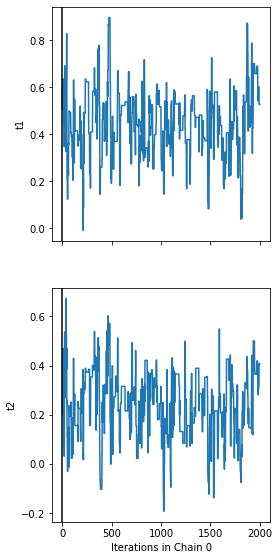

In [15]:
res.plot_traces();

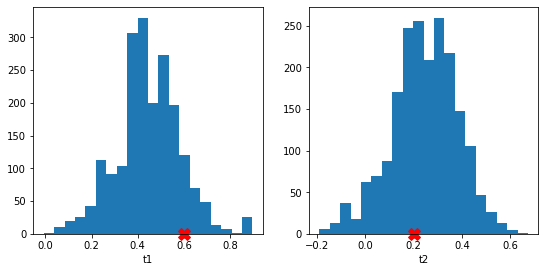

In [16]:
res.plot_marginals(reference_value={'t1': 0.6, 't2': 0.2});

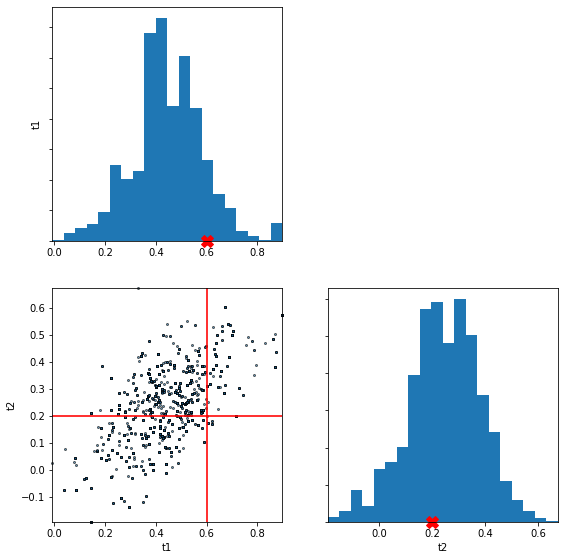

In [17]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2} );

This concludes the standard BSL example. Extensions to the standard method are introduced as extensions to the likelihood function or as alternative likelihood functions.

## BSLasso

In [18]:
from elfi.methods.bsl.select_penalty import select_penalty

In [24]:
shrinkage = 'glasso'
sigma = 1.5
nsim = [100, 300, 500]
penalty, std_value = select_penalty(m, nsim, params, feature_names, sigma=sigma, shrinkage=shrinkage)

In [25]:
std_value

array([1.50527975, 1.4565151 , 1.51103077])

Update `nsim_round` and the likelihood function.

In [31]:
nsim_round = nsim[1]
likelihood = pdf_methods.bsl_likelihood(shrinkage=shrinkage, penalty=penalty[1])

Test:

In [32]:
bslasso = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

In [33]:
res = bslasso.sample(mcmc_iterations, est_post_cov, params0=params0)

Progress [==================================================] 100.0% Complete


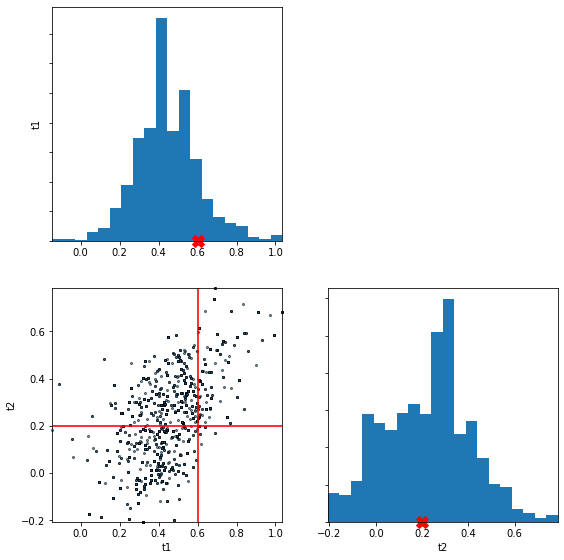

In [34]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2} );

## wBSL

In [49]:
from elfi.methods.bsl.estimate_whitening_matrix import estimate_whitening_matrix

In [50]:
nsim = 20000
W = estimate_whitening_matrix(m, nsim, params, feature_names)

In [51]:
shrinkage = 'warton'
sigma = 1.5
nsim = [100, 300, 500]
penalty, std_value = select_penalty(m, nsim, params, feature_names, whitening=W, sigma=sigma, shrinkage=shrinkage)

In [52]:
std_value

array([1.57553735, 1.51798578, 1.41477096])

Update `nsim_round` and the likelihood function.

In [53]:
nsim_round = nsim[0]
likelihood = pdf_methods.bsl_likelihood(whitening=W, shrinkage=shrinkage, penalty=penalty[0])

Test:

In [54]:
wbsl = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

In [55]:
res = wbsl.sample(mcmc_iterations, est_post_cov, params0=params0)

Progress [==================================================] 100.0% Complete


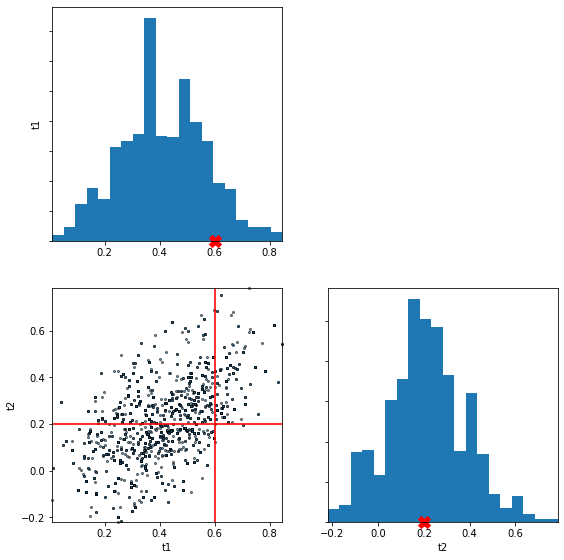

In [56]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2} );

### SemiBSL

[SemiBSL](https://www.tandfonline.com/doi/full/10.1080/10618600.2021.1875839) uses a semi-parametric SL estimator that relaxes the normality assumption. This method is recommended when the summary statistics deviate from normality. The only change to use semiBSL is passing "semiBSL" as the first argument of the `SyntheticLikelihood` node. The sampling step is the same as standard BSL

## R-BSL

Robust BSL ([R-BSL](https://www.tandfonline.com/doi/full/10.1080/10618600.2021.1875839)) is able to perform useful parameter inference even if the model is misspecified. A model is said to be "misspecified in the BSL sense" if the model is unable to replicate the observed summary statistics. R-BSL adds free parameters to absorb the impact of model misspecification. The free parameters either adjusts the sample mean (R-BSL-M) or the sample covariance (R-BSL-V). The adjustment argument of the `SyntheticLikelihood` node determines which method is used.

## Parallelising simulations

A new approach to parallelisation is recommended for BSL methods. The main computational cost from inference with BSL methods is usually from running the simulations. Existing approaches in ELFI parallelise the entire sweep of the graph. This approach differs as we only want to simulate a single node, the `Simulator` node, rather than the whole graph. To parallelise a `Simulator` node, the user can set `parallelise=True` and set the number of processes with the `num_processes` argument. If `num_processes=None` then it defaults to `os.cpu_count()`. Parallelisation is done through the multiprocessing library. There is a trade-off in using this parallelisation approach as the simulations are no longer vectorised.
